# Advanced Machine Learning course: CropGym tutorial
## Nitrogen optimization on the winter wheat crop

CropGym is a WUR-made reinforcement learning platform that trains an agent to optimize the usage of Nitrogen fertilizer on crops. The environment is a crop growth model (also developed in WUR), called LINTUL-3, capable of simulating a nitrogen-limited condition for the growth of plants.

This notebook presents a use case for nitrogen application in winter wheat. An RL agent is trained to decide weekly on applying a discrete amount of nitrogen fertilizer, with the aim of achieving a balance between maximizing yield and minimizing environmental impact.

This notebook is intended to be run on [google-colab](https://colab.research.google.com/). Trained models and derived results are available in the [results](https://github.com/BigDataWUR/PCSE-Gym/tree/master/notebooks/nitrogen-winterwheat/results) folder.

### Install required packages and import required libraries

In [ ]:
# Install libraries
!rm -fr /content/PCSE-Gym && cd /content/ && git clone https://github.com/BigDataWUR/PCSE-Gym.git && git reset --hard 7daa80a
!cd /content/PCSE-Gym && git switch --detach v1.0.0

!pip3 uninstall -y --quiet pcse
!rm -fr /content/pcse && cd /content/ && git clone https://github.com/ajwdewit/pcse.git
!cd /content/pcse && git reset --hard 7daa80a && git apply /content/PCSE-Gym/notebooks/nitrogen-winterwheat/pcse.patch &&  pip3 install --quiet -e .

# hack to install stable-baselines3 v1.5.0 with gym v0.21.1
!pip3 install git+https://github.com/Pythoniasm/gym-fork.git@fix-v0.21.0
!git clone https://github.com/DLR-RM/stable-baselines3
!cd /content/stable-baselines3 && git reset --hard v1.5.0
# ugly hack to make sure that gym v0.21.1 is used, as well as torch 1.11.0 (the latter is needed for reproducibility)
# colab will most likely complain about dependency conflicts, but that's OK for us
!sed -i -e 's/0\.21/0\.21\.1/g' -e 's/torch>=1\.8\.1/torch==1\.11.0/g' /content/stable-baselines3/setup.py
!cd /content/stable-baselines3 && pip3 install -e .

import sys
sys.path += ['/content/pcse','/content/stable-baselines3','/content/PCSE-Gym/','/content/PCSE-Gym/notebooks/nitrogen-winterwheat']

In [2]:
# Some includes
import os
import gym
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set variables
all_years = [*range(1990, 2022)]
train_years = [year for year in all_years if year % 2 == 1]
test_years = [year for year in all_years if year % 2 == 0]
train_locations = [(52,5.5), (51.5,5), (52.5,6.0)]
test_locations= [(52,5.5), (48,0)]
location_to_label = {'52;5.5': 'NL', '48;0': 'FR'}
colors = {'RL':'tab:blue', 'SP':'tab:orange', 'Ceres': 'red'}
markers = {'52;5.5':'o', '48;0':'^'}
random.seed(42)

font = {'weight': 'bold', 'size': 14}
ax = {'titleweight': 'bold', 'titlesize': 14}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **ax)
sns.set_theme(font_scale=1.00)

inputdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat'
resultsdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results'


import itertools
import functools as ft

def read_data(resultsdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results',
              csv_models={"baseline": "fixed.csv", "upperbound": "upperbound.csv",
                          "model": ["model-1.csv", "model-3.csv", "model-5.csv", "model-7.csv", "model-9.csv",
                                    "model-15.csv", "model-19.csv", "model-42.csv", "model-47.csv", "model-70.csv",
                                    "model-74.csv", "model-75.csv", "model-79.csv", "model-88.csv", "model-99.csv"]}
              ):
  df_SP = pd.read_csv(os.path.join(resultsdir, csv_models["baseline"]))
  df_Ceres = pd.read_csv(os.path.join(resultsdir, csv_models["upperbound"] ))
  df_RL = [pd.read_csv(os.path.join(resultsdir, csv_model)) for csv_model in csv_models["model"]]

  dfs = list(itertools.chain([df_SP, df_Ceres, *df_RL]))
  suffix = list(itertools.chain(['_SP', '_Ceres', *[f'_RL_{i}' for i in range(len(df_RL))]]))
  duplicate_cols = ['TMIN', 'TMAX', 'IRRAD', 'RAIN', 'year', 'location']

  for i, df in enumerate(dfs):
    dfs[i].columns = [str(col) if col in duplicate_cols else str(col) + suffix[i] for col in df.columns]
    if i>0:
      dfs[i].drop(columns=duplicate_cols, inplace=True)
  df_merged = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how = 'outer'), dfs)

  #Convert to common units
  df_merged[f'rain'] = 10.0*df_merged[f'RAIN']
  filter_col = [col for col in df_merged if col.startswith('WSO')]
  suffices = ([c.split('_', 1)[1] for c in filter_col])
  for suffix in suffices:
    df_merged[f'fertilizer_{suffix}'] = 10.0 * df_merged[f'fertilizer_{suffix}']
    df_merged[f'WSO_{suffix}'] = 0.01 * df_merged[f'WSO_{suffix}']
    df_merged[f'nitrogen_{suffix}'] = 10.0*(df_merged[f'fertilizer_{suffix}'])

  return df_merged

## Getting to know the RL Environment

To set up a proper agent, one needs to be familiar with the environment of the RL agent. In this case, the environment is the LINTUL-3 crop growth model, made available through PCSE (Python Crop Simulation Environment)

Using PCSE, we can look into different elements of the environment, and how a crop model is defined. In the following section we will play around a bit with the PCSE environment.

There is no extensive knowledge of crop modelling required to train an RL agent for CropGym, but what's important is understanding the important parameters of the crop model and how the RL agent explores the environment.

In [ ]:
# some imports
import os
import pcse
import matplotlib.pyplot as plt
import pandas as pd
import yaml
data_dir = r'/content/PCSE-Gym/pcse_gym/environment/configs'

In the cell below, we will define the files used to parameterize the crop model. There are 3 things to define for the model: the crop itself (winter wheat), the soil specifications (soil properties) and the site specifications (whether it's irrigated or not). This is all loaded and fed into the PCSE file reader function to then concatenate in the parameter provider function.

In [4]:
from pcse.fileinput import PCSEFileReader
from pcse.base import ParameterProvider

cropfile = os.path.join(data_dir, "crop", "lintul3_winterwheat.crop")
soilfile = os.path.join(data_dir, "soil", "lintul3_springwheat.soil")
sitefile = os.path.join(data_dir, "site", "lintul3_springwheat.site")

crop = PCSEFileReader(cropfile)
soil = PCSEFileReader(soilfile)
site = PCSEFileReader(sitefile)

parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)

Before initializing the model, we should obtain weather parameters. Here, we obtain the weather parameters from the power NASA database, specifically for weather in the Netherlands as determined by the lat and long arguments. We can see the range of data that is available with the resolution.

In [5]:
from pcse.db import NASAPowerWeatherDataProvider
weatherdataprovider = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(weatherdataprovider)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2024-05-23
Number of missing days: 0



We should also obtain the agromanagement actions. The file we are about to load contains triggers for actions to do in the crop model. Try running the file and checking its output.

In [6]:
from pcse.fileinput import YAMLAgroManagementReader
agromanagement_file = os.path.join("/content/pcse/pcse/tests/test_data/lintul3_springwheat.agro")
agromanagement = YAMLAgroManagementReader(agromanagement_file)
print(agromanagement)

!!python/object/new:pcse.fileinput.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 1997-01-01:
    CropCalendar:
      crop_end_date: 1997-10-20
      crop_end_type: earliest
      crop_name: wheat
      crop_start_date: 1997-03-31
      crop_start_type: emergence
      max_duration: 366
      variety_name: spring-wheat
    StateEvents: null
    TimedEvents:
    - comment: All nitrogen amounts in g N m-2
      event_signal: apply_n
      events_table:
      - 1997-04-10:
          amount: 10
          recovery: 0.7
      - 1997-05-05:
          amount: 5
          recovery: 0.7
      name: Nitrogen application table



The file defines what steps to do in a certain time range. In the case above it does agormanagement for springwheat, starting from April and ending in October, with two actions of fertilization, one with 10 and the other with 5 gNm-2.

Nevertheless, this file is to do pre-defined actions. Our RL agent in CropGym will not load such a file, but instead do many different trials of fertilizations to optimize the defined reward function.

In the following cell, we will initialize a LINTUL-3 model based on the provided parameters above.

In [7]:
from pcse.models import LINTUL3
lintul = LINTUL3(parameterprovider=parameterprovider,weatherdataprovider=weatherdataprovider,agromanagement=agromanagement)

In [8]:
#run the lintul model until it terminates. When it terminates is defined by the files provided.
lintul.run_till_terminate()

In [9]:
# Here we obtain the output of the models.
output = lintul.get_output()
df = pd.DataFrame(output).set_index("day")
df.tail()

,DVS,TGROWTH,TGROWTHr,LAI,NUPTT,TRAN,TIRRIG,TNSOIL,TRAIN,TRANRF,...,TRUNOF,TDRAIN,TAGBM,TTRAN,WC,WLVD,WLVG,WRT,WSO,WST
day,,,,,,,,,,,,,,,,,,,,,
1997-08-16,1.923165,1411.177591,5.132912,0.732657,22.31,0.593091,0.0,0.03,368.15,0.510703,...,0.0,71.998863,1262.232223,168.226043,0.212948,188.926948,33.578998,43.238586,576.391411,463.334867
1997-08-17,1.946697,1416.310503,4.632450,0.690437,22.34,0.558867,0.0,0.03,368.19,0.476007,...,0.0,71.998863,1267.346972,168.819134,0.212184,190.856350,31.649595,41.959591,583.686719,461.154307
1997-08-18,1.971988,1420.942953,4.151665,0.648929,22.37,0.522433,0.0,0.03,368.25,0.458694,...,0.0,71.998863,1271.963597,169.378001,0.211433,192.753528,29.752418,40.716628,590.636023,458.821628
1997-08-19,1.997969,1425.094618,3.630723,0.608608,22.40,0.496915,0.0,0.03,368.31,0.390041,...,0.0,71.998863,1276.101775,169.900434,0.210716,194.596748,27.909198,39.508616,597.158255,456.437574
1997-08-20,2.000000,1428.725342,3.643017,0.572000,22.43,0.450244,0.0,0.03,368.31,0.439984,...,0.0,71.998863,1279.720714,170.397349,0.209980,196.270219,26.235726,38.335142,602.993291,454.221478


The cell above shows the final few days of the simulation before the end of the simulation. There are 22 variables that are available to monitor. The interesting variables for us are:
* TNSOIL: The available amount of N available in soil to take
* WSO: The weight of the storage organs (grains)
* LAI: The leaf area index
* NUPPT: The total uptake of N over time; how well the crop is absorbing N from the soil.

We can try making a graph of these variables.

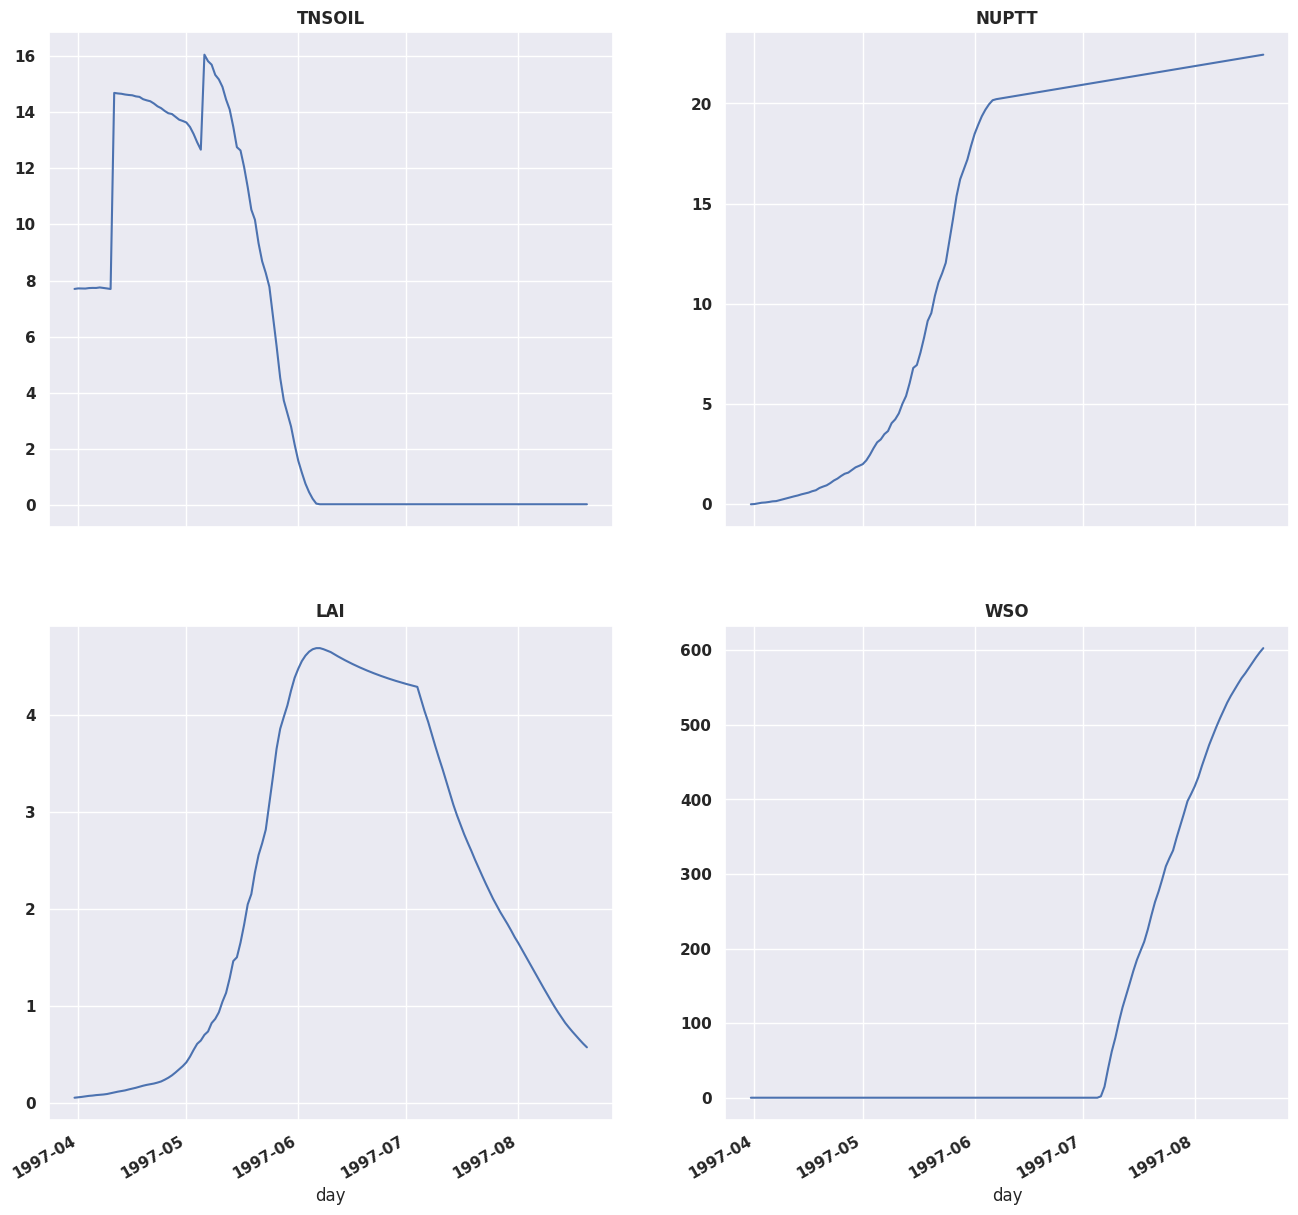

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
#for key, axis in zip(df.columns, axes.flatten()):
df['TNSOIL'].plot(ax=axes[0][0], title='TNSOIL')
df['NUPTT'].plot(ax=axes[0][1], title='NUPTT')
df['LAI'].plot(ax=axes[1][0], title='LAI')
df['WSO'].plot(ax=axes[1][1], title='WSO')


fig.autofmt_xdate()
fig.savefig(os.path.join(data_dir, "lintul3_winterwheat.png"))

#### TO DO 1:
* Look at the graph of TNSOIL. What causes the spikes in the N availability?
* Look at NUPTT. Why does the N uptake seem to crawl at a certain point?
* Look at LAI. What do you think causes the LAI to degrade slightly once then degrade exponentially after a month?
* Look at WSO. What is approximately the end result of the yield? (in gN/m2)

## The RL agent in CropGym

To get familiar with the CropGym setting, we will visualize the results of the paper from [Kallenberg et al., 2023](https://www.cambridge.org/core/journals/environmental-data-science/article/nitrogen-management-with-reinforcement-learning-and-crop-growth-models/358749FAFAA4990B1448DAB7F48D641C).

In CropGym, there are several RL spaces that was defined: the action space, the observation space and the reward function.

The reward function is defined as follows:
\begin{align}\mathit{R_t} = (\mathit{WSO}^{\pi}_{t} - \mathit{WSO}^{\pi}_{t-1}) - (\mathit{WSO}^{0}_{t} - \mathit{WSO}^{0}_{t-1}) - \beta N_{t}\end{align}

with a timestep t, the agent tries to maximize the difference of the weight of the storage organ of a fertilizing policy 𝐖𝐒𝐎ₜ when compared to a policy of not fertilizing at all 𝐖𝐒𝐎ₜᴼ (zero nitrogen policy). The agent is punished by the amount of fertilizer 𝐍ₜ used with a multiplier for the cost β. This cost is a multiplier that mimics the economic cost of nitrogen fertilzer. By default, the value of β is 10.

The timestep is weekly, so one timestep equals 7 days, with an action taken on the 7th day.

The action space is a discrete space of three possible fertilization levels: {0, 2, 4} gN/m2.

The observation space consists of crop parameters that the RL agent can observe; in this case it is 9 variables from the crop and 3 variables from the weather.


In the following cell, a graph will be produced that shows graphs of the nitrogen application and the reward obtained by the trained RL agent. The agent was trained with the PPO algorithm for a subset of years in the range of 1990 and 2022. The it was trained in the Netherlands and tested in France.

Available variables: ['DVS', 'TGROWTH', 'TGROWTHr', 'LAI', 'NUPTT', 'TRAN', 'TIRRIG', 'TNSOIL', 'TRAIN', 'TRANRF', 'NRF', 'GRF', 'TRUNOF', 'TDRAIN', 'TAGBM', 'TTRAN', 'WC', 'WLVD', 'WLVG', 'WRT', 'WSO', 'WST', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'RAIN', 'E0', 'ES0', 'ET0', 'WIND', 'action', 'fertilizer', 'reward', 'growth', 'prob', 'dvs', 'val']
Available years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Available locations: [(48, 0), (52, 5.5)]


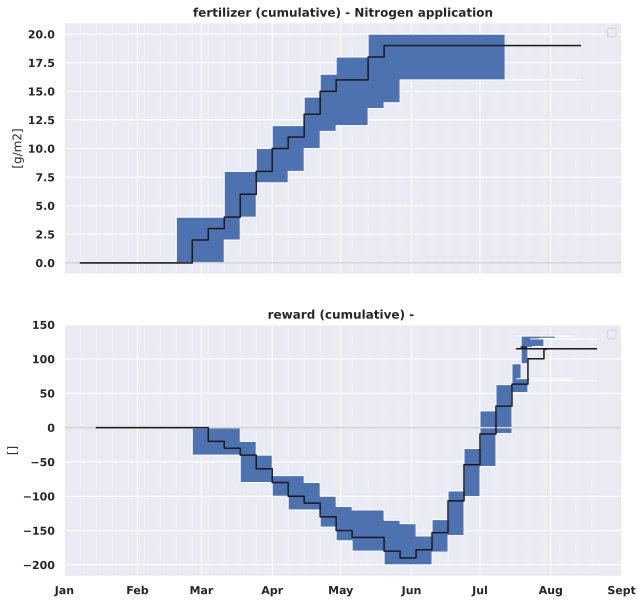

In [11]:
# Policy visualization
import pickle
from helper import plot_variable, get_ylim_dict

# Load paper results from disk
# A few cells below you can generate your own results with one of the available models, or one of the baselines
with open(os.path.join(resultsdir,'results_RL.pickle'), 'rb') as f:
  plot_results = pickle.load(f)

%config InlineBackend.figure_format = 'svg'
sns.set_theme(font_scale=1.00)

all_variables = list(list(plot_results.values())[0][0].keys())
all_years = list(set([k[0] for k in list(plot_results.keys())]))
all_locations = list(set([k[1] for k in list(plot_results.keys())]))
print(f'Available variables: {all_variables}')
print(f'Available years: {all_years}')
print(f'Available locations: {all_locations}')

# Specify plotting variables here (alternative suggestions are provided as commented-out code)
plot_years = test_years #[1992, 2020]
subset_keys = [(year, (52,5.5)) for year in plot_years]
results_subset = {f'{subset_key}': plot_results[subset_key] for subset_key in subset_keys}
plot_variables =  ['fertilizer', 'reward'] #, 'action', 'fertilizer','reward']

plot_average = True #False
if (len(plot_years)) > 5 and not plot_average: print(f'Warning: plotting {plot_years} at once; consider plot_average=True')
figsize = (5*len(plot_variables), 5*len(plot_variables))
fig, axes = plt.subplots(len(plot_variables), 1, sharex=True, figsize=figsize)
for i, variable in enumerate(plot_variables):
  ax = axes if len(plot_variables) == 1 else axes[i]
  plot_variable(results_subset, variable=variable, cumulative_variables = ['fertilizer', 'reward', 'IRRAD','RAIN'], ax=ax, ylim=get_ylim_dict()[variable], plot_average=plot_average, put_legend=True)

#### TO DO 2:
* In the fertilizer graph, what amount did the agent fertilize in total?
* What is the average first amount that the agent fertilized in the start of the season? When is this?
* In the reward graph, why does the graph start moving down, then start moving up again around June?

## Training an RL agent in CropGym

Here we will train an RL agent with the two previously learned RL algorithms: DQN and PPO. The actual training process of the the full cropgym takes almost a whole workday to complete; hence, this notebook provides training with a subset of the locations and years.

### Training a DQN agent

In [12]:
from wrapper import ReferenceEnv
from helper import EvalCallback
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import argparse


# setting the seed
seed = 1

# number of steps for training
nsteps = 10_000
# setting the value for beta
costs_nitrogen = 10

rootdir = '/content/PCSE-Gym'
log_dir = os.path.join(rootdir, 'notebooks', 'nitrogen-winterwheat', 'tensorboard_logs', 'CropGym-Tutorial')

# setting the training and testing years for the PCSE simulations
all_years = [*range(1990, 1993)]
train_years = [year for year in all_years if year % 2 == 1]
test_years = [year for year in all_years if year % 2 == 0]

# locations of the weather train and test; 52,5.5 is the Netherlands, and 48,0 is France.
train_locations = [(52,5.5)]
test_locations = [(48,0)]

# choosing the crop and weather variables that the RL agent can observe; the observation space
crop_features = ["DVS", "TGROWTH", "LAI", "NUPTT", "TRAN", "TNSOIL", "TRAIN", "TRANRF", "WSO"]
weather_features = ["IRRAD", "TMIN", "RAIN"]
action_features = []  # alternative: "cumulative_nitrogen"
tag = f'Seed-{seed}'

In [13]:
#Make the RL environment with a wrapper for PCSE, feeding in all the information defined in the previous cell
env_pcse_train = ReferenceEnv(crop_features=crop_features, action_features=action_features,
                                  weather_features=weather_features,
                                  costs_nitrogen=costs_nitrogen, years=train_years, locations=train_locations,
                                  action_space=gym.spaces.Discrete(3), action_multiplier=2.0)
env_pcse_train = Monitor(env_pcse_train)
env_pcse_train = VecNormalize(DummyVecEnv([lambda: env_pcse_train]), norm_obs=True, norm_reward=True,
                              clip_obs=10000., clip_reward=50000., gamma=0.99)

Below you can start training a DQN model for cropgym. It will take around 11 minutes before it finishes training for 10.000 steps.

In [ ]:
# Start training the DQN model and initialize live tensorboard
# Click on the reload button button on the top right to refresh the tensorboard

# Tensorboard
dqn_model_name = f'{tag}-Ncosts-{costs_nitrogen}-DQN-run'
folder = dqn_model_name + "_1" #Change this based on the run number
log_dir_tensorboard = os.path.join(log_dir, folder)
%load_ext tensorboard
%tensorboard --logdir $log_dir_tensorboard

model_dqn = DQN('MlpPolicy', env_pcse_train, gamma=0.99, seed=seed, verbose=0, tensorboard_log=log_dir)

print(f'train for {nsteps} steps with costs_nitrogen={costs_nitrogen} (seed={seed})')
model_dqn.learn(total_timesteps=nsteps, callback=EvalCallback(test_years=test_years, train_years=train_years,
            train_locations=train_locations, test_locations=test_locations, eval_freq=nsteps),
            tb_log_name=dqn_model_name)


#### TO DO 3:
* In the tensorboard; open images on the tab above and check the WSO growth. How far did the agent manage to make it grow?
* How does the reward look like? Does it seem that there were enough training steps for the DQN agent?
* What was the first action of the agent? **Hint: There are three discrete actions of the agent {0, 2, 4} gN/m2.*

### Training a PPO agent

In [ ]:
#Initializing PPO hyper parameters used in the paper

from wrapper import get_policy_kwargs

hyperparams =   {'batch_size': 64, 'n_steps': 2048, 'learning_rate': 0.0003, 'ent_coef': 0.0, 'clip_range': 0.3,
                    'n_epochs': 10, 'gae_lambda': 0.95, 'max_grad_norm': 0.5, 'vf_coef': 0.5
                    }
hyperparams['policy_kwargs'] = {}
hyperparams['policy_kwargs'] = get_policy_kwargs(crop_features=crop_features, weather_features=weather_features,
                                                  action_features=action_features)
hyperparams['policy_kwargs']['net_arch'] = [dict(pi=[128,128], vf=[128,128])]
hyperparams['policy_kwargs']['ortho_init'] = False

In [ ]:
#Make the RL environment with a wrapper for PCSE, feeding it with the same information
env_pcse_train = ReferenceEnv(crop_features=crop_features, action_features=action_features,
                                  weather_features=weather_features,
                                  costs_nitrogen=costs_nitrogen, years=train_years, locations=train_locations,
                                  action_space=gym.spaces.Discrete(3), action_multiplier=2.0)
env_pcse_train = Monitor(env_pcse_train)
env_pcse_train = VecNormalize(DummyVecEnv([lambda: env_pcse_train]), norm_obs=True, norm_reward=True,
                              clip_obs=10., clip_reward=50., gamma=0.99)


#### TO DO 4:

* Train a PPO agent for 20.000 steps in the cell below and pass the hyperparameters above into the RL agent! *Hint: the hyperparameters are passed when initializing the agent*

If the tensorboard from the DQN is model is still running, it might be required to close the tensorboard beforehand.

In [ ]:
ppo_model_name = f'{tag}-Ncosts-{costs_nitrogen}-PPO-run'
folder = ppo_model_name + "_1" #Change this based on the run number
log_dir_tensorboard = os.path.join(log_dir, folder)
%reload_ext tensorboard
%tensorboard --logdir $log_dir_tensorboard

# TODO 4 here
nsteps =

#### TO DO 5:
* How many times did the agent fertilize? *Hint: look at the action graph in tensorboard*
* Look at the value function in the tensorboard. What does it represent?

### Looking into the Deep RL network used by the RL agent

Here, we will briefly look into the deep neural networks used by the RL agents.
We can print and see the structure of the neural networks that is used by CropGym.

In [ ]:
print(model_dqn.policy)

#### TO DO 6:
* What is the activation function used for the DQN model?
* What is the dimension of the hidden layers of the DQN neural network?
* What is the size of the output layer of the DQN neural network? Why is it that size?
* print the network of the PPO model and describe it!

In [ ]:
# TODO 6 here


You have (briefly) trained an RL agent that still couldn't properly apply nitrogen. With more training time, it's possible to make the agent a bit more intelligent.

#### TO DO 7:
* Train an agent (PPO or DQN) with 200.000 steps!
* Try to vary the inputs and report what you changed and see in the evaluation (call tensor board).

In [ ]:
# Small hints for TO DO 7
# setting the seed
seed = 1

# number of steps for training
nsteps = 10_000
# setting the value for beta
costs_nitrogen = 10

# setting the training and testing years for the PCSE simulations
all_years = [*range(1990, 2022)]
train_years = [year for year in all_years if year % 2 == 1]
test_years = [year for year in all_years if year % 2 == 0]

# locations of the weather train and test; 52,5.5 is the Netherlands, and 48,0 is France.
train_locations = [(52,5.5), (51.5,5), (52.5,6.0)]
test_locations = [(52,5.5), (48,0)]

# choosing the crop and weather variables that the RL agent can observe; the observation space
crop_features = ["DVS", "TGROWTH", "LAI", "NUPTT", "TRAN", "TNSOIL", "TRAIN", "TRANRF", "WSO"]
weather_features = ["IRRAD", "TMIN", "RAIN"]
action_features = []  # alternative: "cumulative_nitrogen"
tag = f'Seed-{seed}'

In [ ]:
#Rest of TO DO 7 here

## Additional things about the paper

Below you can visualize some further results from the paper. In the paper, we obtain the upper bound of the fertilizing policy (i.e., the best practice  amount of fertilizer needed for each year and location). This is a baseline we call "Ceres" the all-knowing (-fertilizer-application). Ceres can apply a continuous, as opposed to discrete, amount of nitrogen.

The cell below will calculate the upper bound of the fertilizer for NL and FR, and then it can be visualized; comparing it with the standard practice and the trained RL agent.

In [15]:
# Statistics
from helper import report_ci

# Specify variable to compute statistics for
var = 'WSO' #reward #fertilizer

df_merged = read_data() #read data stored on disk
df_merged = df_merged[df_merged.year % 2 == 0]

random.seed(42)
n_boot=10000

name_var_RL = [col for col in df_merged.columns if f'{var}_RL' in col]
cols_var_RL = [df_merged.columns.get_loc(col) for col in name_var_RL]

for i, location in enumerate (['52;5.5','48;0']):
  df_boot = df_merged.loc[df_merged["location"] == location]
  boot_RL, boot_SP, boot_delta_RL_SP, boot_Ceres = [], [], [], []
  n_observations=len(df_boot.index)

  # bootstrapping
  for b in range(n_boot):
    obs = random.choices(range(n_observations), k=n_observations)
    seed = random.choices(cols_var_RL, k=n_observations)
    var_RL = df_boot.values[obs, seed]
    var_Ceres = df_boot.values[obs,[df_boot.columns.get_loc(f'{var}_Ceres')]*n_observations]
    boot_Ceres.append(np.median(var_Ceres))
    var_SP = df_boot.values[obs,[df_boot.columns.get_loc(f'{var}_SP')]*n_observations]
    delta_RL_SP = var_RL - var_SP
    boot_RL.append(np.median(var_RL))
    boot_SP.append(np.median(var_SP))
    boot_delta_RL_SP.append(np.median(delta_RL_SP))

  median_Ceres = np.median(df_boot[f'{var}_Ceres'])
  median_SP = np.median(df_boot[f'{var}_SP'])
  median_RL = np.median(pd.concat([df_boot[col] for col in name_var_RL]).to_numpy())
  median_diff = np.median(pd.concat([df_boot[col] - df_boot[f'{var}_SP'] for col in name_var_RL]).to_numpy())

  print(f'**{location_to_label[location]}**')
  print(f'median_Ceres: {median_Ceres:0.2f} {report_ci(boot_Ceres)}')
  print(f'median_SP: {median_SP:0.2f} {report_ci(boot_SP)}[')
  print(f'median_RL: {median_RL:0.2f} {report_ci(boot_RL)}]')
  print(f'median_RL-SP: {median_diff:0.2f} {report_ci(boot_delta_RL_SP, True)}')

<ipython-input-2-2f861f0a0dc1>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged[f'nitrogen_{suffix}'] = 10.0*(df_merged[f'fertilizer_{suffix}'])


**NL**
median_Ceres: 8.96 (95% CI=8.41 9.14)
median_SP: 8.72 (95% CI=8.13 8.94)[
median_RL: 8.81 (95% CI=8.24 9.13)]
median_RL-SP: 0.13 (95% CI=-0.01 0.39) one-sided-p=0.0290
**FR**
median_Ceres: 8.60 (95% CI=4.69 9.60)
median_SP: 8.50 (95% CI=5.80 9.13)[
median_RL: 8.45 (95% CI=5.80 9.13)]
median_RL-SP: -0.04 (95% CI=-0.17 0.13) one-sided-p=0.6459


<ipython-input-2-2f861f0a0dc1>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged[f'nitrogen_{suffix}'] = 10.0*(df_merged[f'fertilizer_{suffix}'])
<ipython-input-16-a73ecc97ccc9>:56: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)


/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-reward-NL.png


<ipython-input-16-a73ecc97ccc9>:56: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)


/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-fertilizer-NL.png


<ipython-input-16-a73ecc97ccc9>:56: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)


/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-fertilizer-NL.png


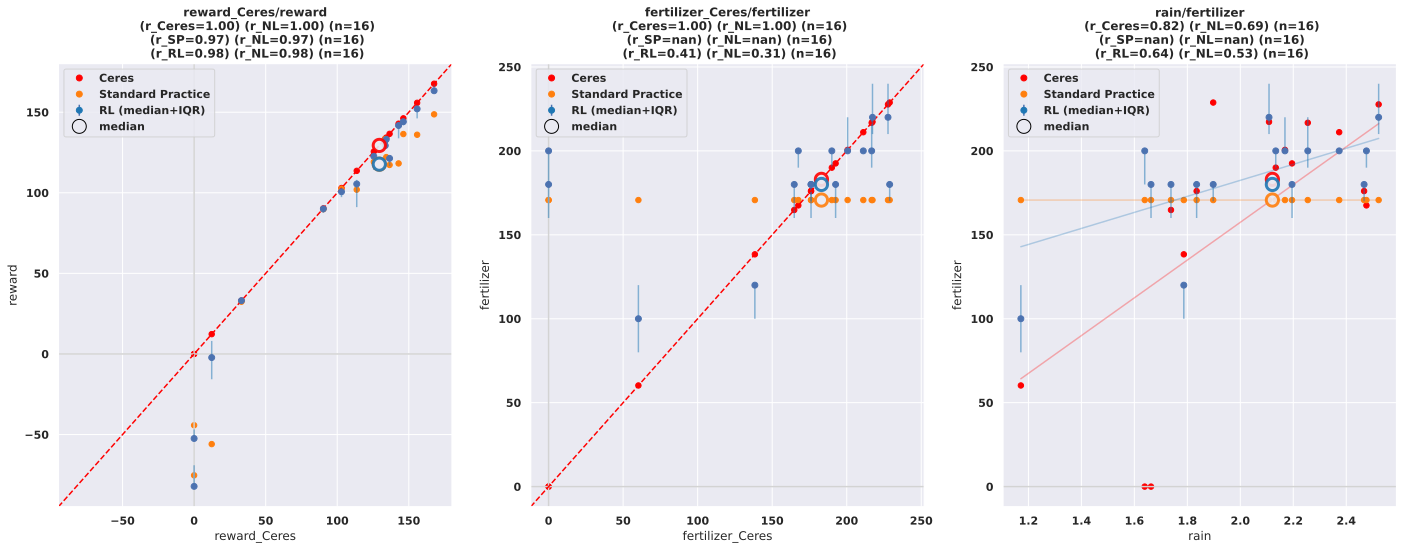

In [16]:
# Scatter plots

%config InlineBackend.figure_format = 'svg'
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
from sklearn.linear_model import Ridge

from helper import identity_line


# specify which variables to plot
markers = {'52;5.5':'o'} # alternatives e.g. {'52;5.5':'o', '48;0':'^'}
plots = {0:('reward_Ceres', 'reward'), 1:('fertilizer_Ceres', 'fertilizer'), 2:('rain', 'fertilizer')} #2:('WSO_Ceres', 'WSO')}
modes = ['Ceres', 'SP', 'RL']
do_annotate = False

df_merged = read_data()
#only include test years (even years):
df_merged = df_merged[df_merged.year % 2 == 0]

sns.set_theme(font_scale=1.00)
location=list(markers.keys())[0]
line = mlines.Line2D([], [], marker=markers[location], color=colors['RL'], linestyle='None', markersize=6)
capline = mlines.Line2D([], [], marker=markers[location], color=colors['RL'], linestyle='None', markersize=0)
barline = LineCollection(np.empty((2,2,2)))
RL= ErrorbarContainer((line, [capline], [barline]), has_xerr=False, has_yerr=True, label='RL (median+IQR)')

fig, axes_scatter = plt.subplots(1, len(plots), figsize=(len(plots)*8,8), sharey='col', sharex='col')
ax_scatter = axes_scatter if len(plots) == 1 else axes_scatter[0]

legend_elements = [mlines.Line2D([], [], marker=markers[location], color=colors['Ceres'], linestyle='None', label='Ceres', markersize=6),
                   mlines.Line2D([], [], marker=markers[location], color=colors['SP'], linestyle='None', label='Standard Practice', markersize=6),
                   RL,
                   mlines.Line2D([], [], marker=markers[location], color='black', linestyle='None', label='median', markersize=14, markerfacecolor=ax_scatter.get_facecolor())]

for p, (x_orig, y_orig) in plots.items():
  same_units = (x_orig.split('_', 1)[0] == y_orig.split('_', 1)[0])
  do_regression = not same_units
  ax_scatter = axes_scatter if len(plots) == 1 else axes_scatter[p]
  title = f'{x_orig}/{y_orig}'
  for i, m in enumerate(modes):
    x = f'{x_orig}'
    y = f'{y_orig}_RL_1' if m == 'RL' else f'{y_orig}_{m}'
    r = df_merged[x].corr(df_merged[y])
    title = title + f'\n (r_{m}={r:0.2f})'
    for i, location in enumerate (list(markers.keys())):
      df_scatter = df_merged.loc[df_merged["location"] == location]
      r = df_scatter[x].corr(df_scatter[y])
      title = title + f' (r_{location_to_label[location]}={r:0.2f}) (n={len(df_scatter[x])})'
      if m == 'RL':
        name_var_RL = [col for col in df_scatter.columns if f'{y_orig}_RL' in col]
        y_median = np.median(df_scatter[name_var_RL], axis=1)
        q25, q75 = np.percentile(df_scatter[name_var_RL], [25, 75], axis=1)
        asymmetric_error = np.array(list(zip(y_median-q25, q75-y_median))).T
        _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)
        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
      else:
        y_median = df_scatter[y].values
        ax_scatter.scatter(df_scatter[x], df_scatter[y], s=30, color=colors[m], marker=markers[location])

      if do_regression:
        reg, = ax_scatter.plot([], [],color=colors[m], alpha=0.3)
        clf = Ridge(alpha=0.5)
        clf.fit(df_scatter[x].values.reshape(-1, 1), y_median.reshape(-1, 1))
        f = clf.predict
        reg.set_data([np.min(df_scatter[x]), np.max(df_scatter[x])], [f(np.min(df_scatter[x]).reshape(-1, 1)),f(np.max(df_scatter[x]).reshape(-1, 1))])

      if do_annotate:
        df_scatter['y'] = y_median
        for index, row in df_scatter.iterrows():
          id = f"{row['year']}"
          ax_scatter.annotate(id, (row[x], row['y']), fontsize=6, color=colors[m]).set_alpha(.7)

      ax_scatter.scatter(np.median(df_scatter[x]), np.median(df_scatter[y]), s=150, edgecolors=colors[m], marker=markers[location], facecolors=ax_scatter.get_facecolor(), linewidths=3, zorder=3).set_alpha(.9)

  if same_units:
    identity_line(ax=ax_scatter, color=colors['Ceres'])
    low_x, high_x = ax_scatter.get_xlim()
    low_y, high_y = ax_scatter.get_ylim()
    low = min(low_x, low_y)
    high = max(high_x, high_y)
    ax_scatter.set_xlim(low, high)
    ax_scatter.set_ylim(low, high)

  if (x_orig.split('_', 1)[0] in ['fertilizer', 'reward']): ax_scatter.axvline(x=0, color='lightgrey', zorder=1)
  if (y_orig.split('_', 1)[0] in ['fertilizer', 'reward']): ax_scatter.axhline(y=0, color='lightgrey', zorder=1)
  ax_scatter.set_xlabel(f'{x}')
  ax_scatter.set_ylabel(f'{y_orig}')
  ax_scatter.set_title(f'{title}')
  ax_scatter.yaxis.set_label_coords(-.1, 0.5)
  ax_scatter.legend(handles=legend_elements, loc='upper left')

  print(f'{resultsdir}/image-scatter-{y_orig}-{location_to_label[location]}.png')
  fig.savefig(f'{resultsdir}/image-scatter-{y_orig}-{location_to_label[location]}.png')